# Задача: написать реализацию алгоритма k-means++, которая будет превосходить базовую реализацию k-means

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets import load_digits

from sklearn.metrics import pairwise_distances_argmin

import random

# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)

## Базовая реализация k-means

In [3]:
def kmeans_find_clusters(X, n_clusters, iter_num=50):
    # 1. Randomly choose clusters

    ind = np.random.permutation(X.shape[0])[:n_clusters]
    centers = X[ind]
   
    for _ in range(iter_num):
 
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

## Датасет MNIST

In [4]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [5]:
centers, labels = kmeans_find_clusters(digits.data, n_clusters=10, iter_num=50)
centers.shape

(10, 64)

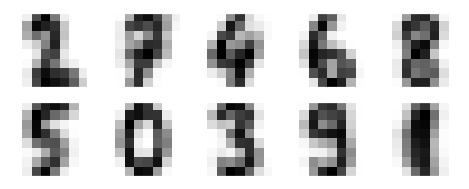

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers_img = centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers_img):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

## Точность кластеризации с помощью accuracy

In [47]:
from scipy.stats import mode

labels_dig = np.zeros_like(labels)
for i in range(10):
    mask = (labels == i)
    labels_dig[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels_dig)

0.7239844184752365

# Реализация k-means++

In [48]:
from scipy.spatial.distance import euclidean
from scipy.stats import mode
from sklearn.metrics import accuracy_score


In [49]:
class KPlusPlus():
    
    def __init__(self, iter_num, K=10, X=digits.data):
        self.iter_num = iter_num
        self.K = K
        self.X = X
        self.n_local_trials = 2 + int(np.log(K))
        self.N = len(X)
        self.center_arr = None

    
    def _dist_from_centers(self):
        # считаем расстояние до центроидов
        cent = self.mu
        X = self.X
        self.Dist = np.array([min([euclidean(x, c) for c in cent])**2 for x in X])
 
    
    def _choose_next_center(self):
        # выбираем кандидатов стать следующим центроидом 
        probs = self.Dist/self.Dist.sum()
        ind = np.random.choice(len(self.X), 1, p=probs)
        return self.X[ind]
    
    def _center_farness(self, c):
        return sum([euclidean(x, c)**2 for x in self.X])
    
    
    def _choose_best_next_center(self):
        # выбираем лучший следующий центроид из кандидатов 
        # так чтобы удаленность точек от него была минимальна
        
        candidates = [self._choose_next_center() for i in range(self.n_local_trials)]
        candidates = [(c, self._center_farness(c)) for c in candidates]
        return min(candidates, key = lambda v: v[1])[0]
 
    def init_centers(self, several_candidates=True):
        # инициализируем центроиды
        
        # флаг если хотим использовать несколько центроидов-кандидатов быть 
        # следующим выбранным центроидом
        self.flag_several_candidates = several_candidates
        
        self.mu = random.sample(list(self.X), 1)
        
        while len(self.mu) < self.K:
            self._dist_from_centers()
            if self.flag_several_candidates:
                c = self._choose_best_next_center()
            else:
                c = self._choose_next_center()
            self.mu.append(c)

    def find_cl(self):
        # основная функция - класстеризация
        
        centers = np.empty((self.K, self.X.shape[1]))
        for i in range(self.K):
            centers[i] = np.array([self.mu[i]])
        
        for i in range(self.iter_num):
            labels = pairwise_distances_argmin(self.X, centers)
            new_centers = np.array([self.X[labels == i].mean(0) for i in range(self.K)])

            if np.all(centers == new_centers):
                break
            centers = new_centers
        return centers, labels


#  Датасет MNIST, kmeans++ и kmeans

In [50]:
digits = load_digits()

In [51]:
kmeans_pp = KPlusPlus(iter_num=50, X=digits.data)

In [52]:
kmeans_pp.init_centers()

In [53]:
centers_pp, labels_pp = kmeans_pp.find_cl()

In [54]:
def get_lab(labels_i):
    labels_dig = np.zeros_like(labels_i)
    for i in range(10):
        mask = (labels_i == i)
        labels_dig[mask] = mode(digits.target[mask])[0]
    return labels_dig
    

In [55]:
labels_dig_pp = get_lab(labels_pp)

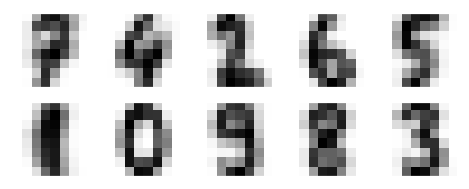

In [56]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers_img = centers_pp.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers_img):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [57]:
print("k_means++, accuracy_score: ", accuracy_score(digits.target, labels_dig_pp))
print("k_means, accuracy_score: ", accuracy_score(digits.target, labels_dig))

k_means++, accuracy_score:  0.8697829716193656
k_means, accuracy_score:  0.7239844184752365


## Считаем значения accuracy + метрики класстеризации

In [18]:
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score

Посчитаем 500 раз accuracy и метрики, выводим только accuracy, смотрим метрики в следующем блоке.

(Для числа итераций 500 у меня считается примерно час)

In [20]:
%%time
num = 500
acc_arr = np.empty((2, num))
f_m = np.empty((2, num))
adj = np.empty((2, num))

for i in range(num):
    kmeans_pp = KPlusPlus(iter_num=50, X=digits.data)
    kmeans_pp.init_centers()
    centers_pp, labels_pp = kmeans_pp.find_cl()
    
    centers, labels = kmeans_find_clusters(digits.data, n_clusters=10, iter_num=50)
    
    labels_dig_pp = get_lab(labels_pp)
    labels_dig = get_lab(labels)
    acc_arr[0, i] = accuracy_score(digits.target, labels_dig_pp)
    acc_arr[1, i] = accuracy_score(digits.target, labels_dig)
    print("[%d/%d] accuracy_score    k_means++: %f,  k_means: %f\n"  % 
          (i+1, num, accuracy_score(digits.target, labels_dig_pp), accuracy_score(digits.target, labels_dig)))
    
    adj[0,i] = adjusted_rand_score(digits.target, labels_dig_pp)
    adj[1,i] = adjusted_rand_score(digits.target, labels_dig)
    f_m[0,i] = fowlkes_mallows_score(digits.target, labels_dig_pp)
    f_m[1,i] = fowlkes_mallows_score(digits.target, labels_dig)

   
    

[1/500] accuracy_score    k_means++: 0.789093,  k_means: 0.722315

[2/500] accuracy_score    k_means++: 0.759043,  k_means: 0.721758

[3/500] accuracy_score    k_means++: 0.790762,  k_means: 0.792988

[4/500] accuracy_score    k_means++: 0.730662,  k_means: 0.788536

[5/500] accuracy_score    k_means++: 0.771842,  k_means: 0.731775

[6/500] accuracy_score    k_means++: 0.638286,  k_means: 0.790762

[7/500] accuracy_score    k_means++: 0.725097,  k_means: 0.791875

[8/500] accuracy_score    k_means++: 0.792988,  k_means: 0.776294

[9/500] accuracy_score    k_means++: 0.732888,  k_means: 0.730106

[10/500] accuracy_score    k_means++: 0.791875,  k_means: 0.730662

[11/500] accuracy_score    k_means++: 0.792432,  k_means: 0.734558

[12/500] accuracy_score    k_means++: 0.789093,  k_means: 0.787980

[13/500] accuracy_score    k_means++: 0.788536,  k_means: 0.728436

[14/500] accuracy_score    k_means++: 0.795771,  k_means: 0.721202

[15/500] accuracy_score    k_means++: 0.724541,  k_means:

[122/500] accuracy_score    k_means++: 0.720646,  k_means: 0.792988

[123/500] accuracy_score    k_means++: 0.697273,  k_means: 0.790762

[124/500] accuracy_score    k_means++: 0.787980,  k_means: 0.725654

[125/500] accuracy_score    k_means++: 0.791319,  k_means: 0.728436

[126/500] accuracy_score    k_means++: 0.780746,  k_means: 0.790762

[127/500] accuracy_score    k_means++: 0.771285,  k_means: 0.726210

[128/500] accuracy_score    k_means++: 0.718976,  k_means: 0.739566

[129/500] accuracy_score    k_means++: 0.727880,  k_means: 0.792432

[130/500] accuracy_score    k_means++: 0.810796,  k_means: 0.795771

[131/500] accuracy_score    k_means++: 0.723984,  k_means: 0.768503

[132/500] accuracy_score    k_means++: 0.720646,  k_means: 0.723984

[133/500] accuracy_score    k_means++: 0.791875,  k_means: 0.788536

[134/500] accuracy_score    k_means++: 0.790206,  k_means: 0.727880

[135/500] accuracy_score    k_means++: 0.723428,  k_means: 0.721202

[136/500] accuracy_score    k_mean

[241/500] accuracy_score    k_means++: 0.786311,  k_means: 0.782415

[242/500] accuracy_score    k_means++: 0.765164,  k_means: 0.779633

[243/500] accuracy_score    k_means++: 0.784641,  k_means: 0.761825

[244/500] accuracy_score    k_means++: 0.759599,  k_means: 0.791875

[245/500] accuracy_score    k_means++: 0.796327,  k_means: 0.753478

[246/500] accuracy_score    k_means++: 0.703395,  k_means: 0.678353

[247/500] accuracy_score    k_means++: 0.744574,  k_means: 0.792432

[248/500] accuracy_score    k_means++: 0.790762,  k_means: 0.787980

[249/500] accuracy_score    k_means++: 0.787423,  k_means: 0.754035

[250/500] accuracy_score    k_means++: 0.790762,  k_means: 0.788536

[251/500] accuracy_score    k_means++: 0.791319,  k_means: 0.799666

[252/500] accuracy_score    k_means++: 0.779076,  k_means: 0.791319

[253/500] accuracy_score    k_means++: 0.682248,  k_means: 0.791875

[254/500] accuracy_score    k_means++: 0.871452,  k_means: 0.698386

[255/500] accuracy_score    k_mean

[360/500] accuracy_score    k_means++: 0.791319,  k_means: 0.745687

[361/500] accuracy_score    k_means++: 0.791319,  k_means: 0.742348

[362/500] accuracy_score    k_means++: 0.778520,  k_means: 0.786311

[363/500] accuracy_score    k_means++: 0.788536,  k_means: 0.785754

[364/500] accuracy_score    k_means++: 0.793545,  k_means: 0.781859

[365/500] accuracy_score    k_means++: 0.799110,  k_means: 0.792432

[366/500] accuracy_score    k_means++: 0.728436,  k_means: 0.731219

[367/500] accuracy_score    k_means++: 0.725654,  k_means: 0.727880

[368/500] accuracy_score    k_means++: 0.790762,  k_means: 0.740122

[369/500] accuracy_score    k_means++: 0.708959,  k_means: 0.744018

[370/500] accuracy_score    k_means++: 0.794101,  k_means: 0.778520

[371/500] accuracy_score    k_means++: 0.739566,  k_means: 0.731219

[372/500] accuracy_score    k_means++: 0.792432,  k_means: 0.789649

[373/500] accuracy_score    k_means++: 0.664997,  k_means: 0.781859

[374/500] accuracy_score    k_mean

[479/500] accuracy_score    k_means++: 0.728993,  k_means: 0.793545

[480/500] accuracy_score    k_means++: 0.783528,  k_means: 0.799110

[481/500] accuracy_score    k_means++: 0.775181,  k_means: 0.639955

[482/500] accuracy_score    k_means++: 0.707846,  k_means: 0.726210

[483/500] accuracy_score    k_means++: 0.773511,  k_means: 0.725654

[484/500] accuracy_score    k_means++: 0.868670,  k_means: 0.791875

[485/500] accuracy_score    k_means++: 0.729549,  k_means: 0.810239

[486/500] accuracy_score    k_means++: 0.732332,  k_means: 0.739566

[487/500] accuracy_score    k_means++: 0.791319,  k_means: 0.731219

[488/500] accuracy_score    k_means++: 0.784641,  k_means: 0.769060

[489/500] accuracy_score    k_means++: 0.742905,  k_means: 0.787980

[490/500] accuracy_score    k_means++: 0.742348,  k_means: 0.717307

[491/500] accuracy_score    k_means++: 0.757373,  k_means: 0.732332

[492/500] accuracy_score    k_means++: 0.868114,  k_means: 0.729549

[493/500] accuracy_score    k_mean

В среднем k-means++ лучше:

In [39]:
# смотрим какие средние получили
print("k_means++, mean accuracy_score: %f +- %f" % (np.mean(acc_arr, axis=1)[0], np.std(acc_arr, axis=1)[0]))
print("k_means, mean accuracy_score: %f +- %f" % (np.mean(acc_arr, axis=1)[1], np.std(acc_arr, axis=1)[1]))

print("difference in mean accuracy_score: ", np.mean(acc_arr, axis=1)[0] - (np.mean(acc_arr, axis=1)[1]))

k_means++, mean accuracy_score: 0.768725 +- 0.042055
k_means, mean accuracy_score: 0.757037 +- 0.040124
difference in mean accuracy_score:  0.011687256538675417


# Использование метрик кластеризации

In [25]:
kmeans_pp = KPlusPlus(iter_num=50, X=digits.data)
kmeans_pp.init_centers()
centers_pp, labels_pp = kmeans_pp.find_cl()
    
centers, labels = kmeans_find_clusters(digits.data, n_clusters=10, iter_num=50)
    
labels_dig_pp = get_lab(labels_pp)
labels_dig = get_lab(labels)

In [26]:
print("k_means++, The Rand Index: ", adjusted_rand_score(digits.target, labels_dig_pp))
print("k_means, The Rand Index: ", adjusted_rand_score(digits.target, labels_dig))

k_means++, The Rand Index:  0.60391098886982
k_means, The Rand Index:  0.5943601528353187


In [27]:
print("k_means++, The Fowlkes-Mallows index: ", fowlkes_mallows_score(digits.target, labels_dig_pp))
print("k_means, The Fowlkes-Mallows index: ", fowlkes_mallows_score(digits.target, labels_dig))

k_means++, The Fowlkes-Mallows index:  0.6541856225563984
k_means, The Fowlkes-Mallows index:  0.6454535138431211


## Выводим значения метрик кластеризации, считаем средние

In [28]:
%%time
num = 500
for i in range(num):
    print("[%d/%d] k_means++, the Rand Index: %f, the Fowlkes-Mallows index: %f" % (i+1, num, adjusted_rand_score(digits.target, labels_dig_pp), fowlkes_mallows_score(digits.target, labels_dig_pp)))
    print("[%d/%d] k_means, the Rand Index: %f, the Fowlkes-Mallows index: %f" % (i+1, num, adjusted_rand_score(digits.target, labels_dig), fowlkes_mallows_score(digits.target, labels_dig)))
    print("-----------------------------")
    


[1/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[1/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[2/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[2/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[3/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[3/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[4/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[4/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[5/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[5/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[6/500] k_means++, the Rand Index: 0.603911, the F

[54/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[54/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[55/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[55/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[56/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[56/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[57/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[57/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[58/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[58/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[59/500] k_means++, the Rand Index: 0.60

[109/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[110/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[110/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[111/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[111/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[112/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[112/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[113/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[113/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[114/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[114/500] k_means, the Rand In

[166/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[166/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[167/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[167/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[168/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[168/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[169/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[169/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[170/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[170/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[171/500] k_means++, the Rand 

[229/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[230/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[230/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[231/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[231/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[232/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[232/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[233/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[233/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[234/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[234/500] k_means, the Rand In

[293/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[294/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[294/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[295/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[295/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[296/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[296/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[297/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[297/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[298/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[298/500] k_means, the Rand In

[344/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[344/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[345/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[345/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[346/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[346/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[347/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[347/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[348/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[348/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[349/500] k_means++, the Rand 

[402/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[403/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[403/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[404/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[404/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[405/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[405/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[406/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[406/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[407/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[407/500] k_means, the Rand In

[455/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[455/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[456/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[456/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[457/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[457/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[458/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[458/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[459/500] k_means++, the Rand Index: 0.603911, the Fowlkes-Mallows index: 0.654186
[459/500] k_means, the Rand Index: 0.594360, the Fowlkes-Mallows index: 0.645454
-----------------------------
[460/500] k_means++, the Rand 

В среднем k-means++ лучше:

In [41]:
print("k_means++, mean The Rand Index: %f +- %f" % (np.mean(adj, axis=1)[0], np.std(adj, axis=1)[0]))
print("k_means, mean The Rand Index: %f +- %f" % (np.mean(adj, axis=1)[1], np.std(adj, axis=1)[0]))

print("difference in mean Rand Index: ",(np.mean(adj, axis=1)[0] - np.mean(adj, axis=1)[1]))

k_means++, mean The Rand Index: 0.642239 +- 0.041694
k_means, mean The Rand Index: 0.631052 +- 0.041694
difference in mean Rand Index:  0.011186924671316323


In [40]:
print("k_means++, mean The Fowlkes-Mallows Index: %f +- %f" % (np.mean(f_m, axis=1)[0], np.std(f_m, axis=1)[0]))
print("k_means, mean The Fowlkes-Mallows Index: %f +- %f" % (np.mean(f_m, axis=1)[1], np.std(f_m, axis=1)[1]))

print("difference in mean Fowlkes-Mallows Index: ", (np.mean(f_m, axis=1)[0] - np.mean(f_m, axis=1)[1]))

k_means++, mean The Fowlkes-Mallows Index: 0.684071 +- 0.033964
k_means, mean The Fowlkes-Mallows Index: 0.675632 +- 0.032027
difference in mean Fowlkes-Mallows Index:  0.00843920934282516
